In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import pickle
import os
import requests
from io import StringIO
import json
from collections import defaultdict

In [2]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# CUDA 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" 사용 디바이스: {device}")

 사용 디바이스: cpu


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\wooll\.cache\kagglehub\datasets\maharshipandya\-spotify-tracks-dataset\versions\1


In [8]:
df = pd.read_csv(r'C:\Users\wooll\OneDrive\문서\GitHub\-\dataset\spotify-tracks-dataset.csv', index_col = 0)
df.sample(5)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
65310,1Z8TPHiKeCUyClxV6WTTIf,TOMORROW X TOGETHER,The Chaos Chapter: FREEZE,0X1=LOVESONG (I Know I Love You) feat. Seori,74,202203,False,0.584,0.836,0,-4.925,1,0.0790,0.05580,0.000000,0.0663,0.484,104.973,4,k-pop
17683,6Ln9akCDdRGYtdSiBfdDwr,The Softies,Holiday In Rhode Island,Sturdies Bay,18,106066,False,0.434,0.372,2,-7.678,1,0.0310,0.74000,0.000105,0.3220,0.616,117.107,4,club
64551,0jX6dTvc8U8Nevz7XBYjzR,Anthony Lazaro,Rock Paper Scissors,Coffee Cup,48,176035,False,0.750,0.284,7,-12.079,1,0.0766,0.89900,0.000109,0.2730,0.593,119.962,4,jazz
13008,52qNIY0h8bzZ410sZPRRWX,Aaron Smith;Alicia Campbell,Outer Level,Outer Level,31,441904,False,0.779,0.519,0,-6.274,1,0.0420,0.23200,0.005390,0.1230,0.731,125.993,4,chicago-house
109283,57Y9YzDxXB2sVlhvqK94sK,York;Kryder,On The Beach (Kryder Remix),On The Beach - Kryder Remix,54,173841,False,0.565,0.899,1,-6.016,1,0.0324,0.00576,0.795000,0.1620,0.111,123.988,4,techno


# EDA

In [6]:
ncols, nrows = df.shape
print(f'Dataset has {ncols} rows and {nrows} columns')

Dataset has 114000 rows and 21 columns


In [7]:
duplicated_rows = df.duplicated().sum()

if duplicated_rows == 0:
    print('There are 0 rows that are duplicated, which means each row in the DataFrame is unique.')
    print('So that we do not need to continue processing duplicate lines')
else:
    print(f'There are {duplicated_rows} rows that are duplicated so we need to drop those {duplicated_rows} rows')
    df = df.drop_duplicates()
    print(f'After drop duplicated rows, there are {df.shape[0]} rows left')

There are 0 rows that are duplicated, which means each row in the DataFrame is unique.
So that we do not need to continue processing duplicate lines


In [9]:
df.dtypes.to_frame('Data Type')

,Data Type
track_id,object
artists,object
album_name,object
track_name,object
popularity,int64
duration_ms,int64
explicit,bool
danceability,float64
energy,float64
key,int64


In [10]:
def open_object_dtype(s):
    dtypes = set()
    dtypes.update(s.apply(type))
    return dtypes

obj_cols = df.select_dtypes(include='object').columns
df[obj_cols].apply(open_object_dtype, axis=0).to_frame('Data Type')

,Data Type
track_id,{<class 'str'>}
artists,"{<class 'float'>, <class 'str'>}"
album_name,"{<class 'float'>, <class 'str'>}"
track_name,"{<class 'float'>, <class 'str'>}"
track_genre,{<class 'str'>}


In [11]:
# Missing values in each row
missing_values_per_row = df.isnull().sum(axis=1)
count_per_missing_value = missing_values_per_row.value_counts().sort_index()

# Print the results
for missing, rows in count_per_missing_value.items():
    print(f'{rows} row(s) have {missing} missing values')

total_rows_with_missing_values = (df.isnull().any(axis=1)).sum()
print(f'Total number of rows with missing values: {total_rows_with_missing_values}')

113999 row(s) have 0 missing values
1 row(s) have 3 missing values
Total number of rows with missing values: 1


In [12]:
numerical_cols = df[df.columns[(df.dtypes == 'float64') | (df.dtypes == 'int64')]]
numerical_cols.shape

(114000, 14)

In [13]:
numerical_cols.sample(5)

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
14810,18,43235,0.915,0.528,5,-6.613,1,0.0674,0.51100,0.000000,0.5320,0.4930,89.989,4
28919,42,182988,0.609,0.639,11,-6.239,1,0.0297,0.01930,0.000006,0.0623,0.4350,129.976,4
53971,47,164571,0.665,0.714,6,-6.462,1,0.0377,0.00388,0.528000,0.1390,0.0353,105.068,4
96590,40,212840,0.437,0.607,7,-3.562,1,0.0308,0.32300,0.000000,0.3890,0.3600,95.836,3
13663,7,338426,0.725,0.538,8,-13.905,1,0.0342,0.50100,0.594000,0.1060,0.3720,108.013,3


In [14]:
numerical_cols.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114000 entries, 0 to 113999
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   popularity        114000 non-null  int64  
 1   duration_ms       114000 non-null  int64  
 2   danceability      114000 non-null  float64
 3   energy            114000 non-null  float64
 4   key               114000 non-null  int64  
 5   loudness          114000 non-null  float64
 6   mode              114000 non-null  int64  
 7   speechiness       114000 non-null  float64
 8   acousticness      114000 non-null  float64
 9   instrumentalness  114000 non-null  float64
 10  liveness          114000 non-null  float64
 11  valence           114000 non-null  float64
 12  tempo             114000 non-null  float64
 13  time_signature    114000 non-null  int64  
dtypes: float64(9), int64(5)
memory usage: 13.0 MB


In [15]:
dist_numerical_cols = numerical_cols.describe().T[['min', 'max']]
dist_numerical_cols['Missing Values'] = numerical_cols.isnull().sum()
dist_numerical_cols['Missing Percentage'] = (numerical_cols.isnull().mean() * 100).round(2)
# The number of -1 values in the 'key' column
dist_numerical_cols.loc['key', 'Missing Values'] = (df['key'] == -1).sum()
dist_numerical_cols

,min,max,Missing Values,Missing Percentage
popularity,0.000,100.000,0,0.0
duration_ms,0.000,5237295.000,0,0.0
danceability,0.000,0.985,0,0.0
energy,0.000,1.000,0,0.0
key,0.000,11.000,0,0.0
loudness,-49.531,4.532,0,0.0
mode,0.000,1.000,0,0.0
speechiness,0.000,0.965,0,0.0
acousticness,0.000,0.996,0,0.0
instrumentalness,0.000,1.000,0,0.0


In [16]:
numerical_cols.describe()

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,114000.000000,1.140000e+05,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000
mean,33.238535,2.280292e+05,0.566800,0.641383,5.309140,-8.258960,0.637553,0.084652,0.314910,0.156050,0.213553,0.474068,122.147837,3.904035
std,22.305078,1.072977e+05,0.173542,0.251529,3.559987,5.029337,0.480709,0.105732,0.332523,0.309555,0.190378,0.259261,29.978197,0.432621
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,1.740660e+05,0.456000,0.472000,2.000000,-10.013000,0.000000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218750,4.000000
50%,35.000000,2.129060e+05,0.580000,0.685000,5.000000,-7.004000,1.000000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000,4.000000
75%,50.000000,2.615060e+05,0.695000,0.854000,8.000000,-5.003000,1.000000,0.084500,0.598000,0.049000,0.273000,0.683000,140.071000,4.000000
max,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


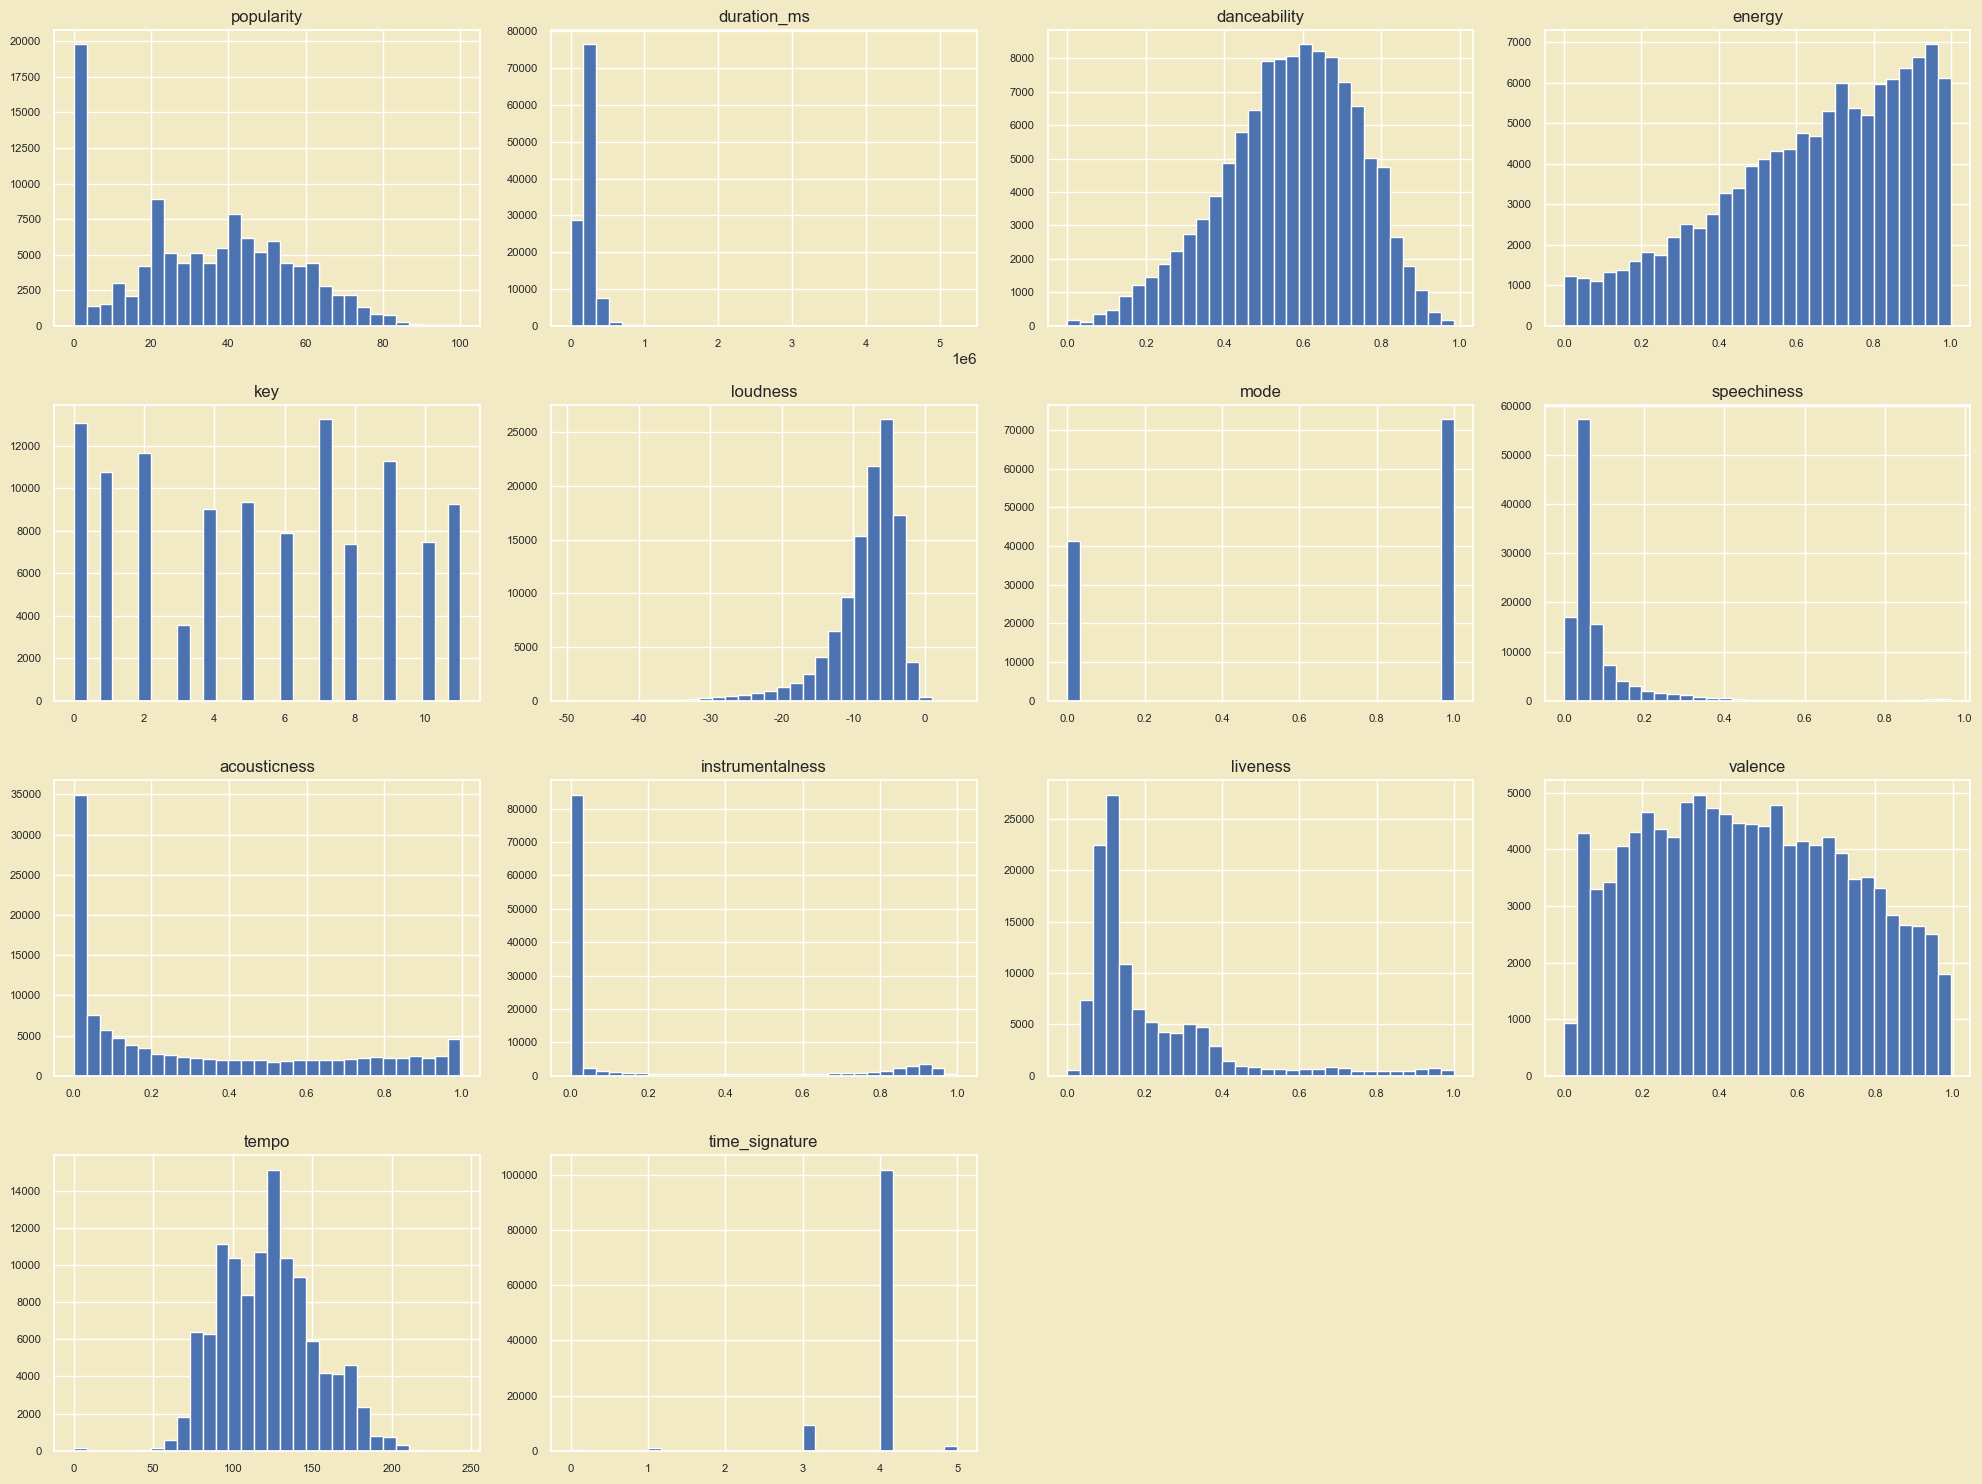

In [17]:
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
numerical_cols.hist(figsize=(20,15), bins=30, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()